In [27]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax  # NOTE: giữ Adamax như bản gốc của bạn

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode

# Nếu bạn dùng KAN như bản gốc:
from tfkan.layers import DenseKAN  # NOTE: giữ DenseKAN(1) như trước

In [28]:
# Define the path to the dataset
base_path = '/Applications/Tien/deepfake/Dataset/celeb_df_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [29]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,222_id32_0007_frame_0028.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,222,28,fake,0
1,522_id7_0003_frame_0027.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,522,27,fake,0
2,501_id60_0007_frame_0022.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,501,22,fake,0
3,487_id59_0008_frame_0023.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,487,23,fake,0
4,239_id34_0004_frame_0007.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,239,7,fake,0
...,...,...,...,...,...,...
32367,082_id1_0001_frame_0027.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,82,27,real,1
32368,186_id2_0001_frame_0007.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,186,7,real,1
32369,200_id30_0005_frame_0014.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,200,14,real,1
32370,460_id56_0007_frame_0012.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,460,12,real,1


In [30]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [31]:
# NOTE (3): Sắp xếp frame theo thời gian để đảm bảo đúng chuỗi
def _frame_index_from_path(p):
    base = os.path.basename(p)
    try:
        return int(base.split('_frame_')[-1].split('.')[0])
    except Exception:
        return 10**9  # nếu lỗi parse, đẩy về cuối
for k in video_dict:
    video_dict[k].sort(key=_frame_index_from_path)


In [32]:
!pip install opencv-python

python3(92786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [33]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from tfkan.layers import Conv2DKAN, DenseKAN  # Import KAN layers
from scipy.stats import mode
from tensorflow.keras.applications import EfficientNetB0

# Giả định đã có
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# ====================== FFT helper ======================
# NOTE (1): THÊM helper chuyển frame -> phổ FFT 2D
def frame_to_fft3(img_bgr, target_size):
    """
    Chuyển frame BGR -> ảnh phổ 2D FFT (log-magnitude), chuẩn hóa [0,1], nhân thành 3 kênh.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)

    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    mag = np.log1p(np.abs(fshift))  # log(1+|F|)
    # Chuẩn hóa [0,1]
    mag -= mag.min()
    denom = (mag.max() + 1e-8)
    if denom > 0:
        mag = mag / denom

    fft3 = np.repeat(mag[..., None], 3, axis=2).astype('float32')  # (H,W,3) in [0,1]
    return fft3

# ====================== Data generator (RGB/FFT) ======================
class VideoSequence(tf.keras.utils.Sequence):
    """
    NOTE (2): Thêm tham số mode. 
    - mode='fft': dùng frame_to_fft3, tắt augment (tránh biến dạng phổ).
    - mode='rgb': giữ logic cũ (augment khả dụng).
    """
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size,
                 sequence_len=10, augment=False, mode='fft'):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.mode = mode

        use_augment = (augment and mode == 'rgb')
        self.datagen = ImageDataGenerator(
            rescale=1./255 if mode == 'rgb' else None,
            rotation_range=15 if use_augment else 0,
            zoom_range=0.1 if use_augment else 0,
            horizontal_flip=use_augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X, batch_y = [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]  # đã sort trước đó
            imgs = []
            for path in frames:
                img = cv2.imread(path)  # BGR
                if img is None:
                    img_proc = np.zeros((*self.img_size, 3), dtype='float32')
                else:
                    if self.mode == 'fft':  # NOTE: xử lý FFT
                        img_proc = frame_to_fft3(img, self.img_size)  # [0,1], 3 kênh
                    else:  # RGB như cũ
                        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)
                        img = img.astype('float32')
                        if self.datagen and (self.datagen.rotation_range or self.datagen.zoom_range or self.datagen.horizontal_flip):
                            img_proc = self.datagen.random_transform(img)
                            img_proc = img_proc / 255.0
                        else:
                            img_proc = img / 255.0

                imgs.append(img_proc)

            # Pad nếu thiếu frame
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))

            batch_X.append(imgs)
            batch_y.append(self.labels[key])

        return np.array(batch_X, dtype='float32'), np.array(batch_y, dtype='int32')

# ====================== Model ======================
def build_model(sequence_len, img_size):
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = False  # NOTE: đóng băng như bản đầu để giảm overfit

    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)

    input_seq = Input(shape=(sequence_len, *img_size, 3))
    x = TimeDistributed(cnn_model)(input_seq)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = DenseKAN(1)(x)  # NOTE: DenseKAN giữ nguyên như bản bạn dùng
    output = tf.keras.activations.sigmoid(x)

    model = Model(inputs=input_seq, outputs=output)
    return model

# ====================== HMM hậu xử lý ======================
def hmm_postprocess(pred_probs, y_true, n_states=2):
    """
    Áp HMM lên vector xác suất dự đoán của tập test trong fold.
    Gợi ý nâng cấp: áp HMM theo CHUỖI FRAME của từng video để đúng nghĩa "chuỗi".
    """
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        mapped_label = mode(state_labels, keepdims=True).mode[0] if len(state_labels) > 0 else 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# ====================== Train K-Fold (FFT mode) ======================
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys     = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(
        trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold
    )

    # NOTE (4): BẬT FFT ở đây — truyền mode='fft' cho 3 generator
    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size,
                              sequence_len, augment=True,  mode='fft')
    val_gen   = VideoSequence(val_keys,   video_dict, labels, batch_size, img_size,
                              sequence_len, augment=False, mode='fft')
    test_gen  = VideoSequence(test_keys,  video_dict, labels, batch_size, img_size,
                              sequence_len, augment=False, mode='fft')

    model = build_model(sequence_len, img_size)
    model.compile(optimizer=Adamax(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # NOTE (5): Đổi tên checkpoint cho dễ phân biệt phiên bản FFT
    model_path = f"best_model_fft_fold{fold}.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop  = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(
        train_gen, validation_data=val_gen, epochs=epochs,
        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1
    )
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred  = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred, zero_division=0),  # NOTE (6)
        'recall': recall_score(y_true, y_hmm_pred, zero_division=0),        # NOTE (6)
        'f1': f1_score(y_true, y_hmm_pred, zero_division=0),                # NOTE (6)
        'auc': roc_auc_score(y_true, y_pred_prob)
    })

print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7063 - accuracy: 0.4833
Epoch 1: val_accuracy improved from -inf to 0.51724, saving model to best_model_fft_fold1.h5
25/25 [==============================] - 43s 2s/step - loss: 0.7063 - accuracy: 0.4833 - val_loss: 0.6937 - val_accuracy: 0.5172 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.5205
Epoch 2: val_accuracy did not improve from 0.51724
25/25 [==============================] - 41s 2s/step - loss: 0.6976 - accuracy: 0.5205 - val_loss: 0.6929 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.5244
Epoch 3: val_accuracy improved from 0.51724 to 0.56322, saving model to best_model_fft_fold1.h5
25/25 [==============================] - 42s 2s/step - loss: 0.6980 - accuracy: 0.5244 - val_loss: 0.6925 - val_accuracy: 0.5632 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.5244
Epoch 4: val_accuracy did not improve from 0.56322
25/25 [==============================] - 48s 2s/step - loss: 0.6981 - accuracy: 0.5244 - val_loss: 0.6923 - val_accuracy: 0.5287 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.5218

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7086 - accuracy: 0.5026
Epoch 1: val_accuracy improved from -inf to 0.47126, saving model to best_model_fft_fold2.h5
25/25 [==============================] - 55s 2s/step - loss: 0.7086 - accuracy: 0.5026 - val_loss: 0.7012 - val_accuracy: 0.4713 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.7108 - accuracy: 0.5013
Epoch 2: val_accuracy improved from 0.47126 to 0.49425, saving model to best_model_fft_fold2.h5
25/25 [==============================] - 54s 2s/step - loss: 0.7108 - accuracy: 0.5013 - val_loss: 0.6992 - val_accuracy: 0.4943 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.5115
Epoch 3: val_accuracy did not improve from 0.49425
25/25 [==============================] - 55s 2s/step - loss: 0.7005 - accuracy: 0.5115 - val_loss: 0.6975 - val_accuracy: 0.4483 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.7030 - accuracy: 0.4949
Epoch 4: val_accuracy did not improve from 0.49425
25/25 [==============================] - 55s 2s/step - loss: 0.7030 - accuracy: 0.4949 - val_loss: 0.6958 - val_accuracy: 0.4598 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.5000


===== Fold 3 =====


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.5051
Epoch 1: val_accuracy improved from -inf to 0.56322, saving model to best_model_fft_fold3.h5
25/25 [==============================] - 65s 2s/step - loss: 0.7037 - accuracy: 0.5051 - val_loss: 0.6948 - val_accuracy: 0.5632 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.5192
Epoch 2: val_accuracy improved from 0.56322 to 0.60920, saving model to best_model_fft_fold3.h5
25/25 [==============================] - 60s 2s/step - loss: 0.6947 - accuracy: 0.5192 - val_loss: 0.6933 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5115
Epoch 3: val_accuracy did not improve from 0.60920
25/25 [==============================] - 58s 2s/step - loss: 0.6931 - accuracy: 0.5115 - val_loss: 0.6945 - val_accuracy: 0.5517 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5333
Epoch 4: val_accuracy did not improve from 0.60920
25/25 [==============================] - 58s 2s/step - loss: 0.6884 - accuracy: 0.5333 - val_loss: 0.6935 - val_accuracy: 0.5747 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.5487

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.5256
Epoch 1: val_accuracy improved from -inf to 0.40230, saving model to best_model_fft_fold4.h5
25/25 [==============================] - 62s 3s/step - loss: 0.6954 - accuracy: 0.5256 - val_loss: 0.7015 - val_accuracy: 0.4023 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.5077
Epoch 2: val_accuracy improved from 0.40230 to 0.42529, saving model to best_model_fft_fold4.h5
25/25 [==============================] - 64s 3s/step - loss: 0.6981 - accuracy: 0.5077 - val_loss: 0.7014 - val_accuracy: 0.4253 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.5064
Epoch 3: val_accuracy improved from 0.42529 to 0.43678, saving model to best_model_fft_fold4.h5
25/25 [==============================] - 60s 2s/step - loss: 0.6993 - accuracy: 0.5064 - val_loss: 0.7004 - val_accuracy: 0.4368 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5513
Epoch 4: val_accuracy did not improve from 0.43678
25/25 [==============================] - 60s 2s/step - loss: 0.6857 - accuracy: 0.5513 - val_loss: 0.7019 - val_accuracy: 0.4253 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================


===== Fold 5 =====


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.4981
Epoch 1: val_accuracy improved from -inf to 0.45977, saving model to best_model_fft_fold5.h5
25/25 [==============================] - 63s 3s/step - loss: 0.7014 - accuracy: 0.4981 - val_loss: 0.6970 - val_accuracy: 0.4598 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5058
Epoch 2: val_accuracy did not improve from 0.45977
25/25 [==============================] - 60s 2s/step - loss: 0.6921 - accuracy: 0.5058 - val_loss: 0.6976 - val_accuracy: 0.4598 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5352
Epoch 3: val_accuracy improved from 0.45977 to 0.56322, saving model to best_model_fft_fold5.h5
25/25 [==============================] - 59s 2s/step - loss: 0.6921 - accuracy: 0.5352 - val_loss: 0.6968 - val_accuracy: 0.5632 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5493
Epoch 4: val_accuracy did not improve from 0.56322
25/25 [==============================] - 61s 2s/step - loss: 0.6896 - accuracy: 0.5493 - val_loss: 0.6960 - val_accuracy: 0.4943 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5352


📊 Tổng kết kết quả các fold:
Fold 1: Accuracy=0.5069, F1=0.0183, AUC=0.5069
Fold 2: Accuracy=0.5023, F1=0.0000, AUC=0.5476
Fold 3: Accuracy=0.5023, F1=0.5263, AUC=0.4975
Fold 4: Accuracy=0.5161, F1=0.3787, AUC=0.4746
Fold 5: Accuracy=0.5278, F1=0.6792, AUC=0.5324


In [34]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.511086
precision    0.510364
recall       0.370659
f1           0.320522
auc          0.511782
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.506912,1.000000,0.009259,0.018349,0.506881
1,2,0.502304,0.000000,0.000000,0.000000,0.547571
2,3,0.502304,0.504202,0.550459,0.526316,0.497452
3,4,0.516129,0.533333,0.293578,0.378698,0.474601
4,5,0.527778,0.514286,1.000000,0.679245,0.532407


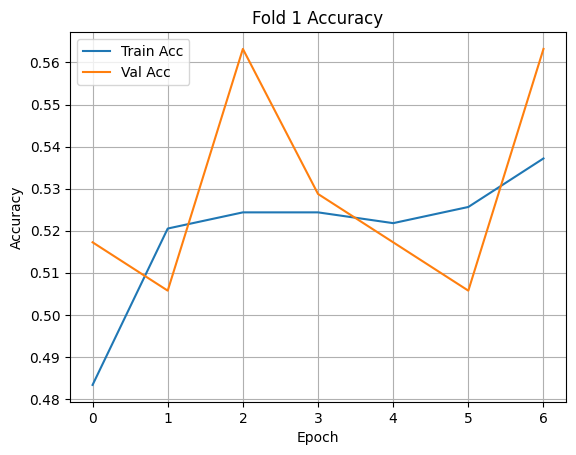

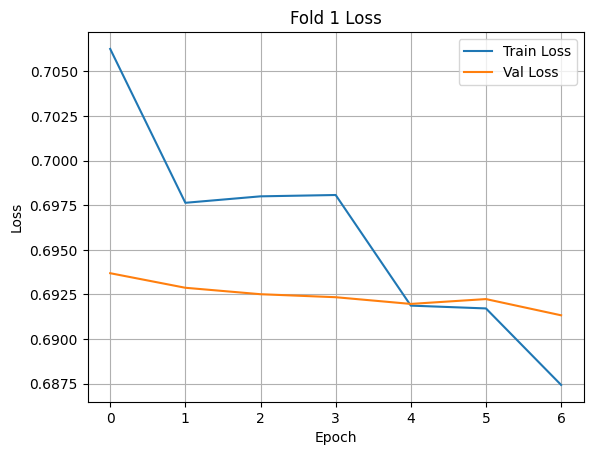

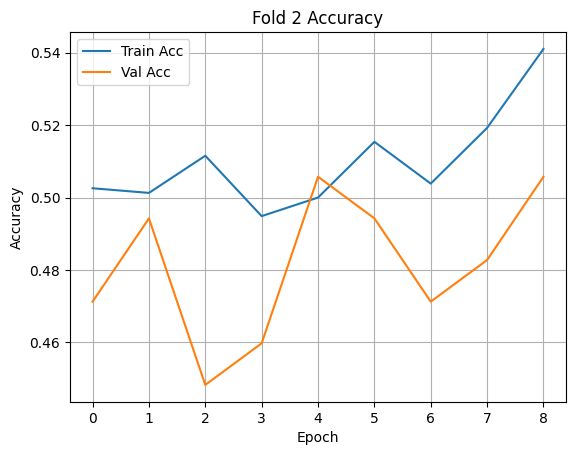

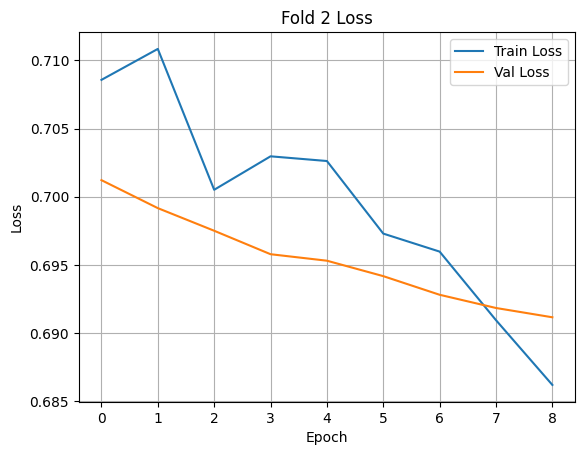

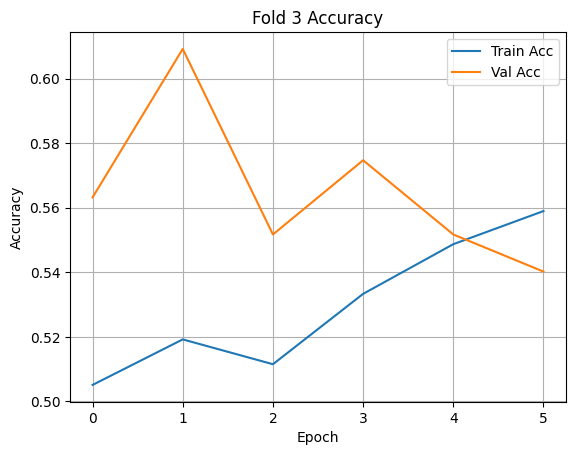

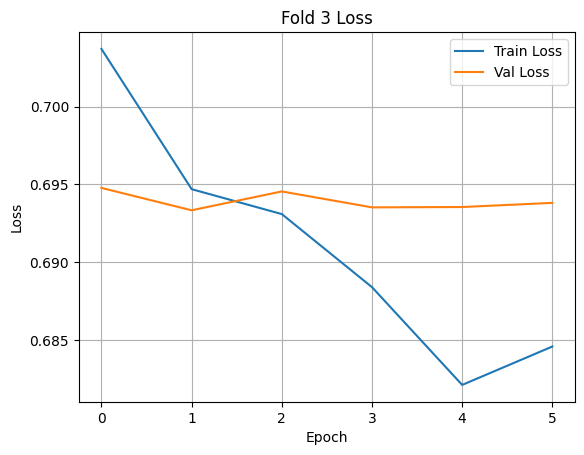

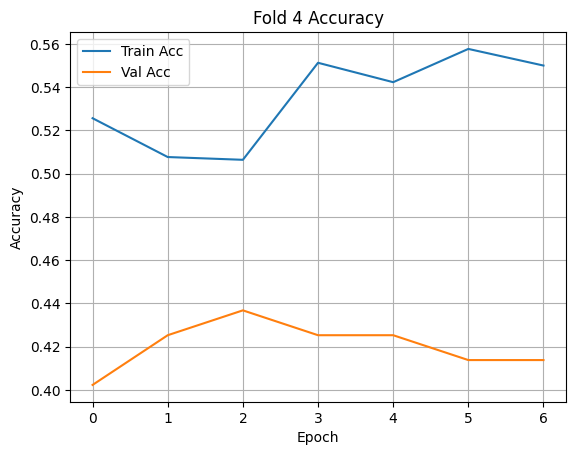

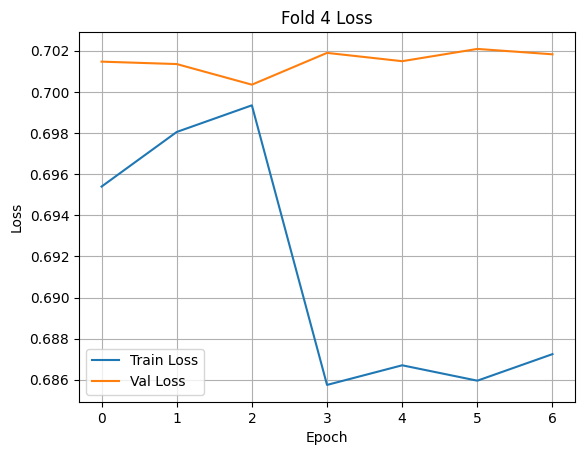

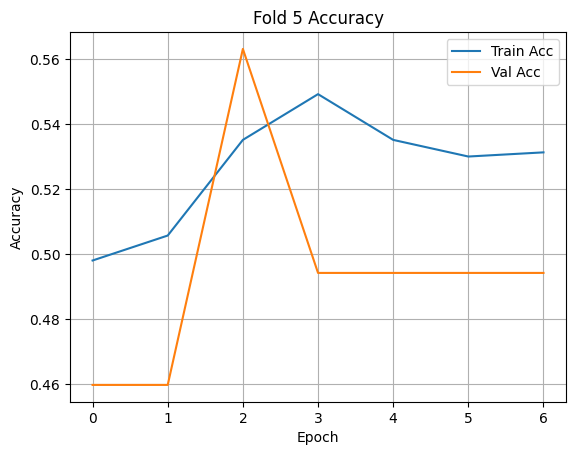

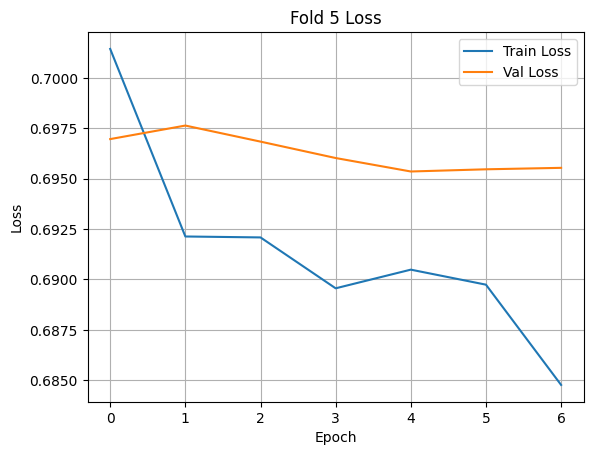

In [35]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [36]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_fft_final.h5")


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.511086
precision    0.510364
recall       0.370659
f1           0.320522
auc          0.511782
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.506912,1.000000,0.009259,0.018349,0.506881
1,2,0.502304,0.000000,0.000000,0.000000,0.547571
2,3,0.502304,0.504202,0.550459,0.526316,0.497452
3,4,0.516129,0.533333,0.293578,0.378698,0.474601
4,5,0.527778,0.514286,1.000000,0.679245,0.532407


In [38]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.511086
precision    0.510364
recall       0.370659
f1           0.320522
auc          0.511782
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.5111
📈 Range Accuracy: 0.0255
📉 Accuracy CV% (std/mean): 2.13%


,fold,accuracy,precision,recall,f1,auc
0,1,0.506912,1.000000,0.009259,0.018349,0.506881
1,2,0.502304,0.000000,0.000000,0.000000,0.547571
2,3,0.502304,0.504202,0.550459,0.526316,0.497452
3,4,0.516129,0.533333,0.293578,0.378698,0.474601
4,5,0.527778,0.514286,1.000000,0.679245,0.532407
